In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import COLLECTIONS as cln
from IPython.display import clear_output
import html5lib

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cnx = create_engine('postgresql://%s:%s@localhost:%s/%s' % (cln.username, 
                                                            cln.password, 
                                                            cln.port,
                                                            cln.db_name))

In [3]:
carrier = 'DL'
airport = 'JFK'

In [4]:
query = """SELECT * FROM 
                (SELECT * FROM ontimeperformance
                 JOIN weatherairportlinks ON weatherairportlinks."IATA" = ontimeperformance."Origin"
                 WHERE "Carrier" = '%s' AND "Origin" = '%s') AS sub
           JOIN weather ON weather."Date" = sub."FlightDate" AND
                           weather."StationID" = sub."StationID" """ % (carrier, airport)
query

'SELECT * FROM \n                (SELECT * FROM ontimeperformance\n                 JOIN weatherairportlinks ON weatherairportlinks."IATA" = ontimeperformance."Origin"\n                 WHERE "Carrier" = \'DL\' AND "Origin" = \'JFK\') AS sub\n           JOIN weather ON weather."Date" = sub."FlightDate" AND\n                           weather."StationID" = sub."StationID" '

In [5]:
df = pd.read_sql_query(query, cnx)

In [10]:
len(pd.unique(df['PerformanceID']))

112100

In [7]:
df.head(20)

,PerformanceID,File_Name,FlightDate,Carrier,TailNum,FlightNum,Origin,OriginCityName,OriginStateName,Dest,...,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,IATA,StationID,StationID,Date,Obsv_Type,Obsv_Value
0,2010_01_011979023521467912478N3769L,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N3769L,749,JFK,New York,New York,SAN,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,WT18,1
1,2010_01_011979023521467912478N3769L,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N3769L,749,JFK,New York,New York,SAN,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,TMAX,50
2,2010_01_011979023521467912478N3769L,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N3769L,749,JFK,New York,New York,SAN,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,TMIN,0
3,2010_01_011979023521467912478N3769L,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N3769L,749,JFK,New York,New York,SAN,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,PRCP,10
4,2010_01_011979023521467912478N3769L,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N3769L,749,JFK,New York,New York,SAN,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,SNOW,0
5,2010_01_011979023521467912478N3769L,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N3769L,749,JFK,New York,New York,SAN,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,SNWD,0
6,2010_01_011979023521467912478N3769L,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N3769L,749,JFK,New York,New York,SAN,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,AWND,24
7,2010_01_011979023521467912478N3769L,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N3769L,749,JFK,New York,New York,SAN,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,FMTM,2359
8,2010_01_011979023521467912478N3769L,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N3769L,749,JFK,New York,New York,SAN,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,PGTM,2355
9,2010_01_011979023521467912478N3769L,On_Time_On_Time_Performance_2010_1.zip,2010-01-01,DL,N3769L,749,JFK,New York,New York,SAN,...,0.0,NaN,NaN,NaN,JFK,USW00094789,USW00094789,2010-01-01,WDF2,320


In [8]:
for col in df.columns:
    print(col, ':', df[col].iloc[0])

PerformanceID : 2010_01_011979023521467912478N3769L
File_Name : On_Time_On_Time_Performance_2010_1.zip
FlightDate : 2010-01-01 00:00:00
Carrier : DL
TailNum : N3769L
FlightNum : 749
Origin : JFK
OriginCityName : New York
OriginStateName : New York
Dest : SAN
DestCityName : San Diego
DestStateName : California
CRSDepTime : 19:30:00
DepTime : 19:28:00
DepTimeBlk : 1900-1959
DepDelay : -2.0
DepDelayMinutes : 0.0
DepDel15 : 0.0
CRSArrTime : 23:26:00
ArrTime : 23:52:00
ArrTimeBlk : 2300-2359
ArrDelay : 26.0
ArrDelayMinutes : 26.0
ArrDel15 : 1.0
TaxiOut : 103.0
WheelsOff : 21:11:00
WheelsOn : 23:48:00
TaxiIn : 4.0
Cancelled : False
Diverted : False
CRSElapsedTime : 416.0
ActualElapsedTime : 444.0
AirTime : 337.0
Flights : 1.0
Distance : 2446.0
DistanceGroup : 10.0
CarrierDelay : 0.0
WeatherDelay : 0.0
NASDelay : 26.0
SecurityDelay : 0.0
LateAircraftDelay : 0.0
FirstDepTime : nan
TotalAddGTime : nan
LongestAddGTime : nan
IATA : JFK
StationID : StationID    USW00094789
StationID    USW00094789

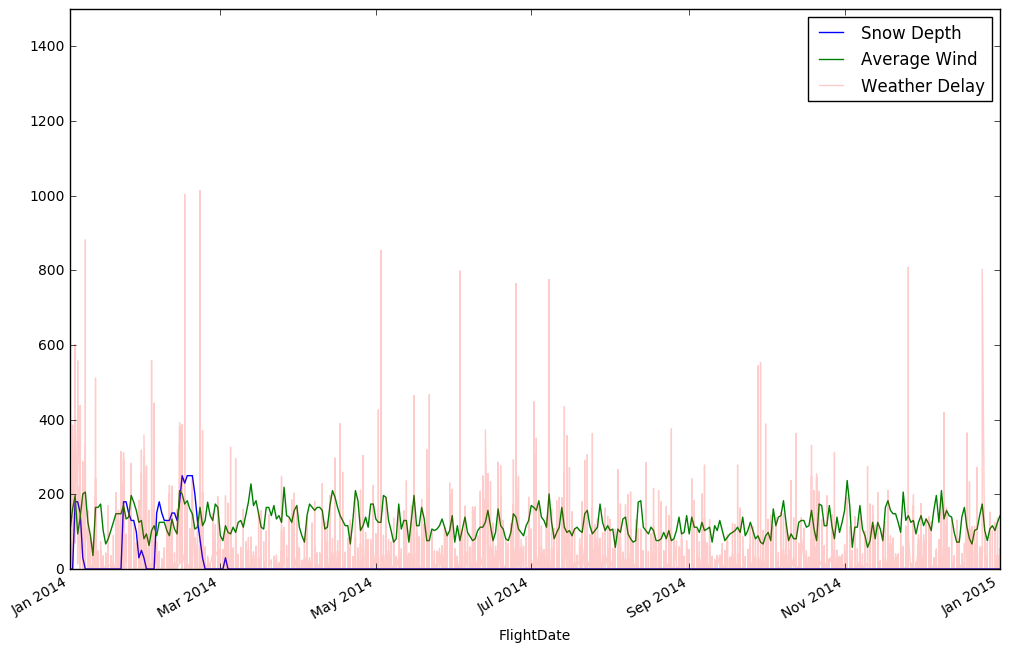

In [29]:
import datetime as dt
fig, ax = plt.subplots(1,1,figsize=(12,8))
df[df['Obsv_Type'] == 'SNWD'].plot('FlightDate', 'Obsv_Value', ax=ax, label='Snow Depth')
df[df['Obsv_Type'] == 'WSF5'].plot('FlightDate', 'Obsv_Value', ax=ax, label='Average Wind')
df[df['Obsv_Type'] == 'SNWD'].plot('FlightDate', 'DepDelay', ax=ax, alpha=0.2, label='Weather Delay')
ax.set_ylim(0, 1500)
ax.set_xlim(dt.datetime(2014,1,1), dt.datetime(2015,1,1));